In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flat = nn.Flatten()
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

In [5]:
model = CIFAR10Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
n_epochs = 50
losses = []
for epoch in range(n_epochs):
    model.train()  # Ensure model is in training mode
    for inputs, labels in trainloader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate model on test data
    model.eval()  # Ensure model is in evaluation mode
    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)
            acc += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
    acc /= count
    print(f"Epoch {epoch}: model accuracy {acc * 100:.2f}% - Loss: {loss.item()}")

Epoch 0: model accuracy 36.71% - Loss: 1.9986473321914673
Epoch 1: model accuracy 42.77% - Loss: 1.932824969291687
Epoch 2: model accuracy 45.58% - Loss: 1.795927882194519
Epoch 3: model accuracy 49.80% - Loss: 1.349557638168335
Epoch 4: model accuracy 52.80% - Loss: 1.8886668682098389
Epoch 5: model accuracy 55.04% - Loss: 1.4192626476287842
Epoch 6: model accuracy 57.11% - Loss: 1.1361083984375
Epoch 7: model accuracy 58.87% - Loss: 0.8656560778617859
Epoch 8: model accuracy 62.07% - Loss: 0.991005003452301
Epoch 9: model accuracy 64.08% - Loss: 0.978624701499939
Epoch 10: model accuracy 65.98% - Loss: 0.9561692476272583
Epoch 11: model accuracy 67.78% - Loss: 1.8793853521347046
Epoch 12: model accuracy 69.26% - Loss: 0.8227128386497498
Epoch 13: model accuracy 71.61% - Loss: 1.2465729713439941
Epoch 14: model accuracy 73.31% - Loss: 0.8859433531761169
Epoch 15: model accuracy 74.97% - Loss: 0.9043049216270447
Epoch 16: model accuracy 76.81% - Loss: 0.9036852121353149
Epoch 17: model

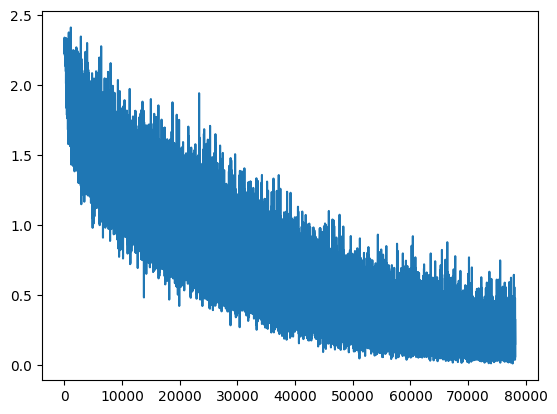

In [7]:
plt.plot(losses, label='Train Loss')

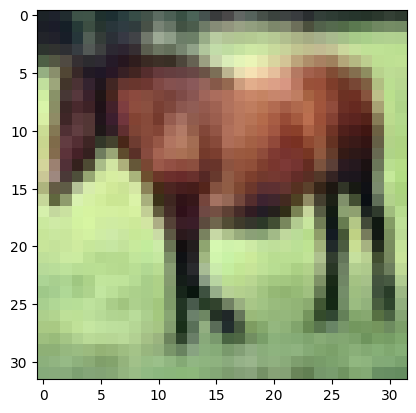

In [8]:
plt.imshow(trainset.data[7])
plt.show()

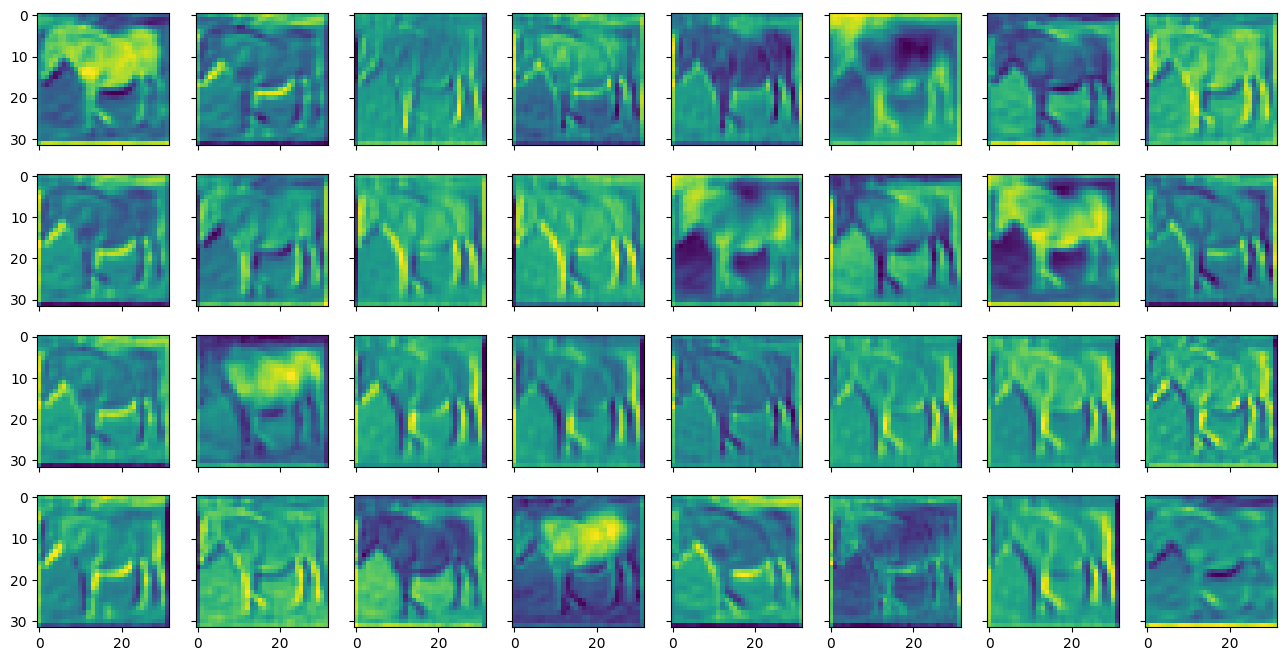

In [11]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2).to(device)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X).to('cpu')

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

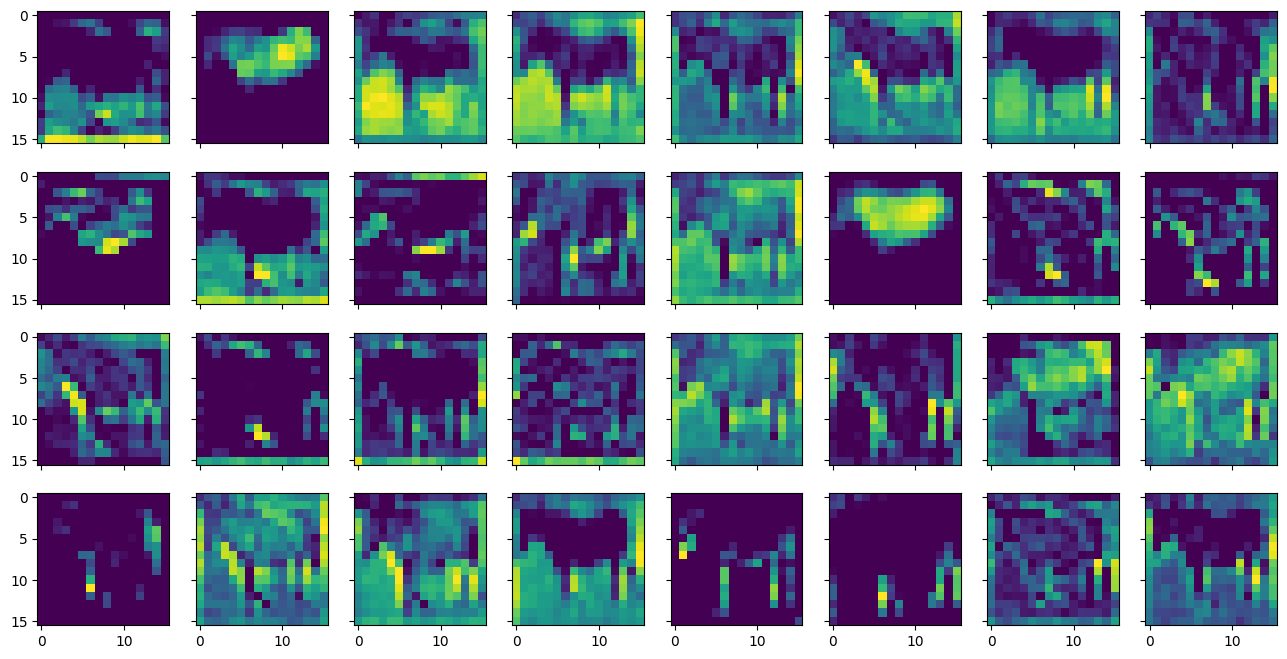

In [14]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2).to(device)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)
    feature_maps = model.drop1(feature_maps)
    feature_maps = model.act2(model.conv2(feature_maps))
    feature_maps = model.pool2(feature_maps)

feature_maps = feature_maps.to('cpu')

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()